In [17]:
import numpy as np
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

dateparse = lambda dates: [datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in dates]
    
dataset = pd.read_csv("city_hour.csv", index_col=0, parse_dates=['Datetime'], date_parser=dateparse)

dataset.drop('AQI_Bucket', axis=1, inplace=True)
dataset.fillna(method='bfill', inplace=True)

col_names = dataset.columns

dataset = dataset.loc['Delhi']
dataset.to_csv('delhiHourData.csv')

df = pd.read_csv("delhiHourData.csv", header=0, index_col=1)
del df['City']
df = df['SO2']
df.head()


Datetime
2015-01-01 01:00:00    3.41
2015-01-01 02:00:00    3.88
2015-01-01 03:00:00    2.83
2015-01-01 04:00:00    4.33
2015-01-01 05:00:00    6.17
Name: SO2, dtype: float64

In [18]:
df.to_frame()

,SO2
Datetime,
2015-01-01 01:00:00,3.41
2015-01-01 02:00:00,3.88
2015-01-01 03:00:00,2.83
2015-01-01 04:00:00,4.33
2015-01-01 05:00:00,6.17
...,...
2020-06-30 20:00:00,10.64
2020-06-30 21:00:00,10.59
2020-06-30 22:00:00,10.20


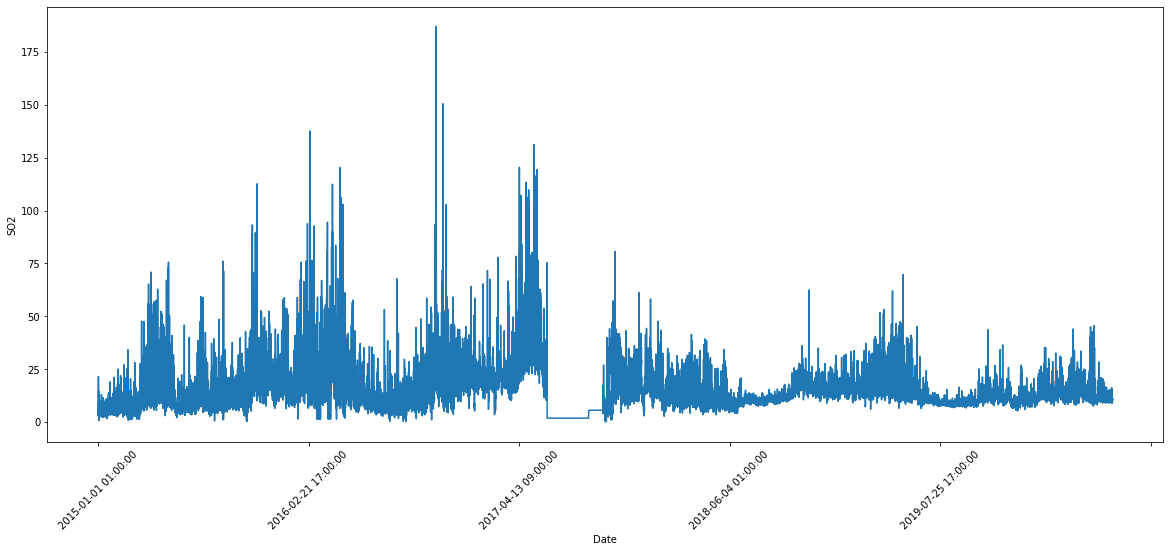

In [19]:
df.plot(x='Datetime',y='SO2',figsize=(20,8))
plt.xticks(rotation=45)
plt.ylabel("SO2")
plt.xlabel("Date")

plt.show()

In [4]:
import math

dataset  = df.values
dataset = dataset.reshape(-1, 1)
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

38554

In [5]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
scaled_data = sc.fit_transform(dataset)
scaled_data

array([[0.4843412 ],
       [0.4692738 ],
       [0.43586765],
       ...,
       [0.0522031 ],
       [0.05376951],
       [0.05749907]])

In [6]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
num = 24

for i in range(num, len(train_data)):
    x_train.append(train_data[i-num:i , 0])
    y_train.append(train_data[i , 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x, y, z = x_train.shape
x_train = x_train.reshape((x, y*z))

In [7]:
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(x_train, y_train)

SVR()

In [8]:
test_data = scaled_data[training_data_len-24: , :]
x_test = []
y_test = dataset[training_data_len:,:]

for i in range(num, len(test_data)):
      x_test.append(test_data[i-num:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x, y, z = x_test.shape
x_test = x_test.reshape((x, y*z))

In [9]:
predictions = regressor.predict(x_test)

predictions = predictions.reshape(-1, 1)
predictions = sc.inverse_transform(predictions)

In [10]:
#RMSE

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
rmse

51.50897219444015

In [11]:
#MAE

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)
mae

46.51666230928476

In [12]:
#R2

from sklearn.metrics import r2_score
r2 = r2_score(y_test, predictions)
r2

0.6622965827096449